# Project Topic

I wanted to take the project in a different direction than the Neural Networks (NN) we have encountered so far. All of the models we have worked with revolved around using a NN to learn some topic and then predict or create information from that topic. 

I have been fascinated with the concept of teaching machines to interact with the world and to learn how to navigate an evironment. This project is an attempt to apply a NN to a robotic process problem and then introduce a new type of NN called deep Q learning to see if it can better handle the challenge. 

Specifically, I create a really simple graphical game for the computer to play. The ai has 60 seconds to move the mouse up to 5 pixels per 80 ms and try and reach a randomly generated red ball. The ball randomly moves every 5 seconds if it hasn't been reached yet and there is a point scored each time the AI can get the mouse over to the ball before the ball moves. The play space is large enough that often it is impossible to reach across from one side to the other in the 5 seconds. 

The next thing I created was an algorithm that can play the game based solely on moving the mouse closer to the target mathematically. This served two purposes, 1. as a theoretical ideal player to compare the NN to and 2. a data generator for the first NN model. 

One last thing to note, the scripts in this notebook are copies of the attached python scripts. Jupyter notebook doesn't work with the mouse control required to play this game when the scripts are run in the cell. However there are calls to run the python scripts in the background that can be invoked to show the game playing. 

### Algorithm Decision Maker

In [1]:
# Play this cell to watch the arbitrary decision maker find the red cell

!python algoplayer.py

### Or have a look at this recording


<img src="Videos/algo.gif" alt="nn training" width="800" height="800">


# Data

The trainig data for the first NN was generated from a 27 minute long recording of the alogorithm playing the game. It resulted in 20,000 recordings of the current mouse position, the target position, the new chosen position and the loss calculation. 

In [3]:
import csv
train_data = []
with open('train data.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        train_data.append([float(x) for x in row])

In [10]:
# Training data samples
print('Start X, Start Y, Target X, Target Y, Next X, Next Y, Loss ')
train_data[:20]

# loss is 0 for all the recording because the algorithm chooses moves with no loss by definition

Start X, Start Y, Target X, Target Y, Next X, Next Y, Loss 


[[1524.0, 19.0, 1054.0, 578.0, 1519.0, 24.0, 0.0],
 [1519.0, 24.0, 1054.0, 578.0, 1514.0, 29.0, 0.0],
 [1514.0, 29.0, 1054.0, 578.0, 1509.0, 34.0, 0.0],
 [1509.0, 34.0, 1054.0, 578.0, 1504.0, 39.0, 0.0],
 [1504.0, 39.0, 1054.0, 578.0, 1499.0, 44.0, 0.0],
 [1499.0, 44.0, 1054.0, 578.0, 1494.0, 49.0, 0.0],
 [1494.0, 49.0, 1054.0, 578.0, 1489.0, 54.0, 0.0],
 [1489.0, 54.0, 1054.0, 578.0, 1484.0, 59.0, 0.0],
 [1484.0, 59.0, 1054.0, 578.0, 1479.0, 64.0, 0.0],
 [1479.0, 64.0, 1054.0, 578.0, 1474.0, 69.0, 0.0],
 [1474.0, 69.0, 1054.0, 578.0, 1469.0, 74.0, 0.0],
 [1469.0, 74.0, 1054.0, 578.0, 1464.0, 79.0, 0.0],
 [1464.0, 79.0, 1054.0, 578.0, 1459.0, 84.0, 0.0],
 [1459.0, 84.0, 1054.0, 578.0, 1454.0, 89.0, 0.0],
 [1454.0, 89.0, 1054.0, 578.0, 1449.0, 94.0, 0.0],
 [1449.0, 94.0, 1054.0, 578.0, 1444.0, 99.0, 0.0],
 [1444.0, 99.0, 1054.0, 578.0, 1439.0, 104.0, 0.0],
 [1439.0, 104.0, 1054.0, 578.0, 1434.0, 109.0, 0.0],
 [1434.0, 109.0, 1054.0, 578.0, 1429.0, 114.0, 0.0],
 [1429.0, 114.0, 1054.0, 5

In [8]:
# Training data length

len(train_data)

20000

<IPython.core.display.Javascript object>


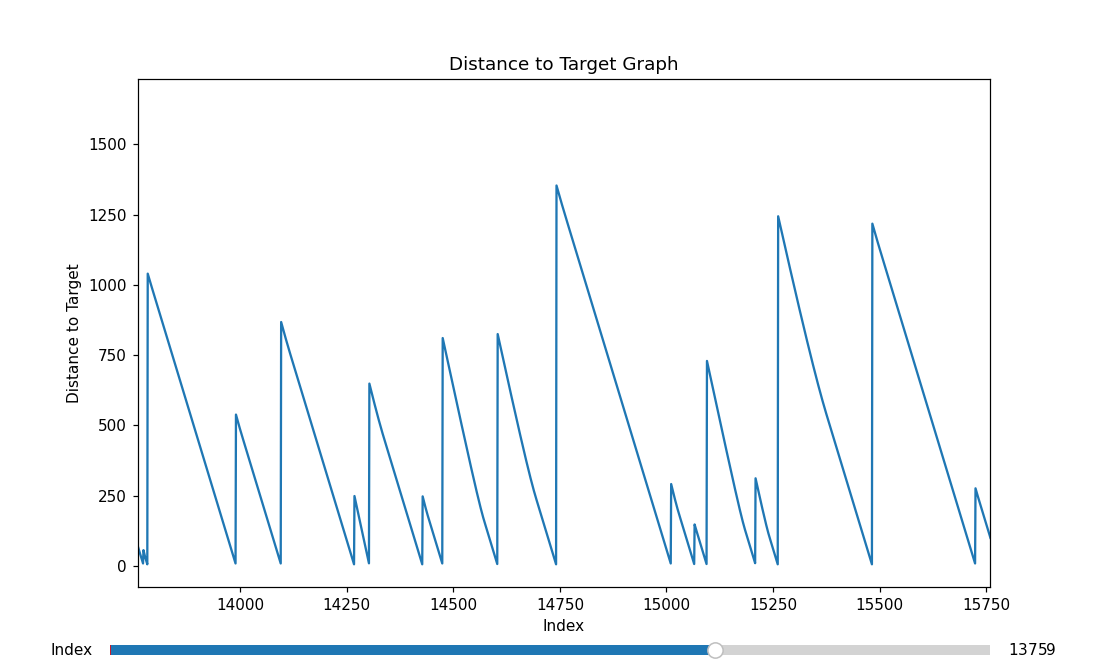

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.widgets as widgets
import math

# Calculate the distance between two points
def distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

# Defining the Data
start_x, start_y, target_x, target_y, new_x, new_y, speed_loss = zip(*train_data)

# Calculate the distance to the target
distances = [distance(sx, sy, tx, ty) for sx, sy, tx, ty in zip(start_x, start_y, target_x, target_y)]

fig, ax = plt.subplots(figsize=(10, 6))

# Distance to the target
ax.plot(distances, label="Distance to Target")
ax.set_ylabel("Distance to Target")
ax.set_xlabel("Index")

ax.set_title("Distance to Target Graph")

# A slider to explore the graph
slider_ax = plt.axes([0.1, 0.0, 0.8, 0.03])
slider = widgets.Slider(slider_ax, 'Index', 0, len(distances) - 1, valinit=0, valstep=1)

# Update the graph based on the slider value
def update(val):
    index = int(slider.val)
    ax.set_xlim(index, index + 2000)  # zoom level (2000 data points visible)
    fig.canvas.draw_idle()

slider.on_changed(update)
update(0)  # Initialize the graph

# Show
plt.show()

The graph demonstrates that the algorithm was able to repeatedly close the gap on the target and click on it. There was no time limit so it was always successful. The difference in timing was related directly to distance from the target when it was moved. 

# Model Architecture

The next step is to bring in Neural Network models to learn to play this game 

The first model attempted is a fully connected (dense) feedforward model.
It has 4 hidden layers using ReLU. It outputs only 2 values, an x and y value based on the prediction of the next x and y coordinates from the input coordinates and the relation to the target. 

### Build Model

### Mouse Movement decider

Mouse movement is determined by a prediction of what the NN thinks is the next best move based on the recordings of the best mouse mover model.

### Loading Data and fitting the model

In [12]:
# Play this cell to watch the Neural Network decision maker train on the data and then attempt to find the red cell
# Training takes about 30 seconds to a minute. The output from the training will print after the game is closed. 

!python nnplayer.py

Epoch 1/50

2000/2000 [==============================] - 2s 846us/step - loss: 3041.4995 - val_loss: 13.6722
Epoch 2/50

2000/2000 [==============================] - 2s 792us/step - loss: 47.1891 - val_loss: 240.0871
Epoch 3/50

2000/2000 [==============================] - 2s 849us/step - loss: 77.7747 - val_loss: 14.4859
Epoch 4/50

2000/2000 [==============================] - 2s 837us/step - loss: 75.3635 - val_loss: 37.9019
Epoch 5/50

2000/2000 [==============================] - 2s 841us/step - loss: 39.9706 - val_loss: 334.8477
Epoch 6/50

2000/2000 [==============================] - 2s 874us/step - loss: 56.0566 - val_loss: 9.9613
Epoch 7/50

2000/2000 [==============================] - 2s 887us/step - loss: 35.5646 - val_loss: 8.5307
Epoch 8/50

2000/2000 [==============================] - 2s 879us/step - loss: 42.2017 - val_loss: 24.6806
Epoch 9/50

2000/2000 [==============================] - 2s 861us/step - loss: 36.1095 - val_loss: 16.3574
Epoch 10/50

2000/2000 [===========

2024-03-03 21:39:53.943275: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2024-03-03 21:39:56.953910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.




### Or have a look at this recording


<img src="Videos/nn.gif" alt="nn training" width="800" height="800">

### Feed Forward Neural Network performance

The NN didn't learn to succeed at the game, earning 0 points. But it did learn the general rule of move toward the circle.  I would have been willing to run the experiment for longer, but it didn't look like it would ever reach the circle. I also knew it wasn't learning from the experience so running it for longer wouldn't have any good effect. 

# Deep Q Learning

Deep Q-Learning is a built up reinformcement model that approaches the problem from the other side. Instead of teaching a NN on a recording of good or expected behavior, the Q model explores the feature space and learns how to navigate based on rewards or punishments when it's actions are beneficial or not. 

The Q algorithm exists outside of Neural Networking and is an attempt to completely comprehend an actionable space. It might learn all the moves the checker based on all possible states of pieces. Deep Q-learning takes advantage of the theory that neural networks are a universal algorithm approximator and attempts to approximate the desired Q algorithm. 

In this case, the learner is not given any historical data, but instead interacts with the feature space, making random decisions 10% of the time. (epsilon =0.1) Each decision is graded based on how close it gets to moving the mouse toward the target at a speed of 5 pixels. The model slowly learns through trial and error to move toward the target. It is not quick enough to  beat the 5 second timer, but it does eventually get to the positions when given enough time. 

The Q Learning model testing is just an adaptation of the same Dense fully connected network in the feed forward NN. Instead of training it on correct behavior, the model is fit as it plays the game. The one modification is to add leaky ReLU to prevent the death of neurons as the model learns. 

The model must also be controlled differently, the Q learning does better if it is given a limited set of actions to perform which in this case are movement in the 8 cardinal directions from center. The reward is also the opposite of loss from the NN. 

The reward is structured to expect a movement speed of 5 toward the target and to reduce rewards for any other action. 

### Have a look at these recordings

<table>
  <tr>
    <td>
      <figure>
        <img src="Videos/qL1.gif" alt="Minute 1" width="400" height="400">
        <figcaption>Minute 1</figcaption>
      </figure>
    </td>
    <td>
      <figure>
        <img src="Videos/qL2.gif" alt="Minute 5" width="400" height="400">
        <figcaption>Minute 5</figcaption>
      </figure>
    </td>
  </tr>
  <tr>
    <td>
      <figure>
        <img src="Videos/qL3.gif" alt="Minute 15" width="400" height="400">
        <figcaption>Minute 15</figcaption>
      </figure>
    </td>
    <td>
      <figure>
        <img src="Videos/qL4.gif" alt="Minute 30" width="400" height="400">
        <figcaption>Minute 30</figcaption>
      </figure>
    </td>
  </tr>
</table>

### Reward Structure

I did attempt the Q-Learning model with a different reward structure. One that gave increasingly large rewards for moving toward the target and negative rewards (punishments) when moving away from the target. The results of that reward strucure showed some improvement, but not enough to call the model "good" at the game

<table>
  <tr>
    <td>
      <figure>
        <img src="Videos/qL1b.gif" alt="Minute 1" width="400" height="400">
        <figcaption>Minute 1</figcaption>
      </figure>
    </td>
    <td>
      <figure>
        <img src="Videos/qL2b.gif" alt="Minute 5" width="400" height="400">
        <figcaption>Minute 5</figcaption>
      </figure>
    </td>
  </tr>
  <tr>
    <td>
      <figure>
        <img src="Videos/qL3b.gif" alt="Minute 15" width="400" height="400">
        <figcaption>Minute 15</figcaption>
      </figure>
    </td>
    <td>
      <figure>
        <img src="Videos/qL4b.gif" alt="Minute 30" width="400" height="400">
        <figcaption>Minute 30</figcaption>
      </figure>
    </td>
  </tr>
</table>

### Absolute Vs Relative

The last attempt I made was rewrite the model to look at the relative position of the mouse to the circle instead of using the absolute positions. This model was much better at finding the circles and I think it is because the model was trying to decide what to do at each point and had to encode the relative location of the circle to the mouse somewhere in the model. Using relative mouse positions helped simplify the information required down to just looking at the location of the mouse compared to where it needs to go since the Q learning actions are all relative anyway. Basically, the model can ignore the current position and just use the relative positions to make the action decisions. 

def mouse_move_decision(target):
    absolute_x, absolute_y = target
    current_position = mouse.get_position()
    mouse_x, mouse_y = current_position

    relative_x, relative_y = absolute_x - mouse_x, absolute_y - mouse_y
    current_state = np.array([[mouse_x, mouse_y, relative_x, relative_y]])


    action = epsilon_greedy(current_state, epsilon)
    new_mouse_x, new_mouse_y = apply_action(action)
    new_position = new_mouse_x, new_mouse_y

    relative_x, relative_y = absolute_x - new_mouse_x, absolute_y - new_mouse_y
    new_state = np.array([[new_mouse_x, new_mouse_y, relative_x, relative_y]])

    # Calculate reward
    reward = calculate_reward(current_state, new_state)

    # Update Q-values
    q_values = model.predict(current_state)
    next_q_values = model.predict(new_state)
    q_values[0, action] = q_values[0, action] + alpha * (reward + gamma * np.max(next_q_values) - q_values[0, action])

    # Train the model with the updated Q-values
    model.fit(current_state, q_values, epochs=1, verbose=0)

    return current_position, new_position

In [13]:
# Play this cell to watch the Deep Q-learning decision start playing and attempt to find the red cell
# Since training occurs on the fly, there is no training time at the outset. Give it time and it will find a red circle. 

!python qlearn.py

0.6659151565986363

1/1 [==============================] - 0s 77ms/step

1/1 [==============================] - 0s 15ms/step

1/1 [==============================] - 0s 15ms/step
0.6690162011231552

1/1 [==============================] - 0s 15ms/step

1/1 [==============================] - 0s 14ms/step

1/1 [==============================] - 0s 15ms/step
0.6722639471407941

1/1 [==============================] - 0s 14ms/step

1/1 [==============================] - 0s 15ms/step

1/1 [==============================] - 0s 14ms/step
0.6756671580320328

1/1 [==============================] - 0s 15ms/step

1/1 [==============================] - 0s 14ms/step

1/1 [==============================] - 0s 15ms/step
-3.9178084076952686

1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 15ms/step

1/1 [==============================] - 0s 15ms/step
0.6920136535861119

1/1 [==============================] - 0s 14ms/step

1/1 [==============================]

2024-03-03 21:53:22.468578: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2024-03-03 21:53:25.716941: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.




### Or have a look at these recordings when I ran this

<table>
  <tr>
    <td>
      <figure>
        <img src="Videos/qL1c.gif" alt="Minute 1" width="400" height="400">
        <figcaption>Minute 1</figcaption>
      </figure>
    </td>
    <td>
      <figure>
        <img src="Videos/qL2c.gif" alt="Minute 5" width="400" height="400">
        <figcaption>Minute 5</figcaption>
      </figure>
    </td>
  </tr>
  <tr>
    <td>
      <figure>
        <img src="Videos/qL3c.gif" alt="Minute 15" width="400" height="400">
        <figcaption>Minute 15</figcaption>
      </figure>
    </td>
    <td>
      <figure>
        <img src="Videos/qL4c.gif" alt="Minute 30" width="400" height="400">
        <figcaption>Minute 30</figcaption>
      </figure>
    </td>
  </tr>
</table>

# Conclusion 

Includes all of the following: basic reiteration of result and discussion of learning and takeaways and discussion of why something didn’t work, and suggestions for ways to improve.

The goal was to experiement with getting a Neural Network to learn to play a game. The game was arbitrarily easy and the network never got better than the ideal algorithm could. However, I learned a lot about training neural networks and how it might be handled so I think the goal was accomplished.

A basic NN can learn the general idea of the game, but lacks the specific knowledge of what to do with the mouse position other than kind of move toward the target. 

The Q learning model did a much better job of learning how to reach the target and slowly got better at the task. However, it seemed to reach a plateau after only a few minutes of training and never got any better at the game. Improving the reward model helped some but the big breakthrough came when using relative target locations which helped simplify the model. 